# Pipelines!

In this notebook we can look at the Scikitlearn's Pipeline functionality. When productionizing a model, having a single pipeline object can be a priceless time saver.

### Structure: 
A pipeline starts with some data, applies a series of transformations, and culminates on an estimator of some kind. Pipelines have 2 key methods:

    fit: the internal estimators/transformers of the pipeline will learn from the training data
    predict: the data will be transformed/estimated upon without modifying the pipeline

### The data

For this notebook we'll use the classic iris dataset.
![](http://www.pybloggers.com/wp-content/uploads/2015/09/ratherreadblog.comwp-contentuploads201509iris_scatter-9c511da385a5344b661e2153e84c28382116721d.png)

In [218]:
# The data
import pandas as pd
from sklearn.model_selection import train_test_split
data = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/resource-datasets/master/iris/iris.csv')

data.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [219]:
X = data.drop('Name', axis=1)
y = data['Name'].map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

### Forming a basic pipeline

In [222]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # a transformer
from sklearn.linear_model import LogisticRegression # an estimator

# A pipeline consists of a list of "steps", 
# each step is a tuple of the form: 
#      (name of the step, object that implements the appropiate functionality)

pipeline1 = Pipeline([('scaler', StandardScaler()),
                     ('logreg', LogisticRegression())])



In [223]:
# usage
pipeline1.fit(X_train, y_train)
pipeline1.score(X_test, y_test)

0.8222222222222222

### A not so basic example

In [221]:
# transformers
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA
from umap import UMAP # you may not have the umap library, it's awesome https://github.com/lmcinnes/umap; pip install umap-learn

# estimators
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


pipeline2 = Pipeline([
    ('scaler', QuantileTransformer(output_distribution='normal')),
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('dimensionality_reduction', PCA(n_components=5)),
    ('logreg', LogisticRegression(C=0.1))
])

In [192]:
# usage
pipeline2.fit(X_train, y_train)
pipeline2.score(X_test, y_test)

0.9333333333333333

In [224]:
# you can use the pipeline class to easily try out various combinations of features, feature engineering, hyperparametsrs and models

pipeline3 = Pipeline([
    #('scaler1', QuantileTransformer(output_distribution='normal')),
    #('scaler2', QuantileTransformer(output_distribution='uniform')),
    #('scaler3', StandardScaler()),
    #('scaler4', MinMaxScaler()),
    #('polynomial_features', PolynomialFeatures(degree=3)),
    #('dimensionality_reduction_PCA', PCA(n_components=5)),
    #('dimensionality_reduction_UMAP', UMAP(n_components=5)),
    #('model_lr', LogisticRegression(C=0.1))
    ('model_rfc', RandomForestClassifier(n_estimators=100, n_jobs=-1))
])

pipeline3.fit(X_train, y_train)
pipeline3.score(X_test, y_test)

0.9555555555555556

# Pipelines are easy to productionize!!!

In most cases, you can direcly save a trained pipeline to disk, and load it from disk ready to make predictions

In [225]:
import pickle

pipeline3.fit(X_train, y_train)

# saves the pipeline to disk
pickle.dump(pipeline3, open('my_pipeline.pickle', 'wb'))

In [226]:
# loads the pipeline from disk
inference_pipeline = pickle.load(open('my_pipeline.pickle', 'rb'))

# ready for inference
inference_pipeline.predict(X_test)

array([0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       2, 0, 2, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0, 1, 2, 2, 0, 1, 2,
       1])

# Building your own transformers

you can! They just have to implement the .fit() and .transform() methods. For most cases, a functional transformer using the FunctionTransformer class is more than enough.

See here how we can use it to inject visualizations into our pipeline

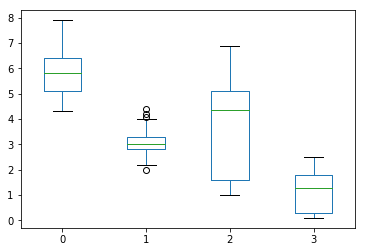

In [227]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer


def boxplot(X):
    data = pd.DataFrame(X)
    data.plot(kind='box')
    plt.show()
    return X


v = FunctionTransformer(func=boxplot)
_ = v.fit_transform(X, y)

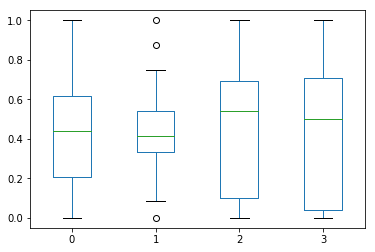

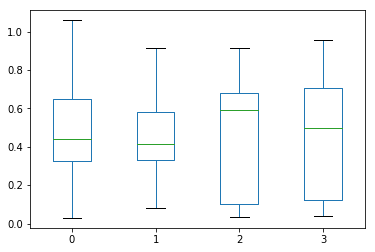

0.9555555555555556

In [228]:
# Usage in a pipeline

pipeline4 = Pipeline([
    #('scaler1', QuantileTransformer(output_distribution='normal')),
    #('scaler2', QuantileTransformer(output_distribution='uniform')),
    #('scaler3', StandardScaler()),
    ('scaler4', MinMaxScaler()),
    ('boxplot', FunctionTransformer(func=boxplot)),
    #('polynomial_features', PolynomialFeatures(degree=3)),
    #('dimensionality_reduction_PCA', PCA(n_components=5)),
    #('dimensionality_reduction_UMAP', UMAP(n_components=5)),
    #('model_lr', LogisticRegression(C=0.1))
    ('model_rfc', RandomForestClassifier(n_estimators=100, n_jobs=-1))
])

pipeline4.fit(X_train, y_train)
pipeline4.score(X_test, y_test)

TRAINING ========================================


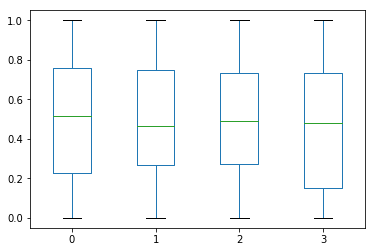

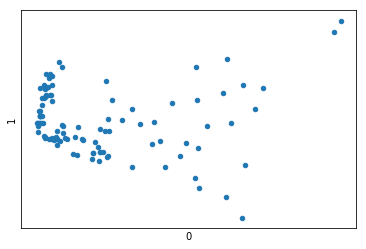

INFERENCE ========================================


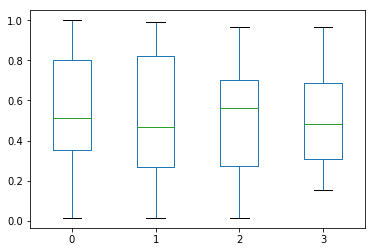

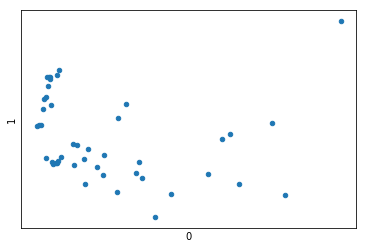

0.9555555555555556

In [229]:
# Another example

def projection2d(X, target=None):
    data = pd.DataFrame(X)

    if target:
        data['target'] = target
        data.plot(kind='scatter', x=0, y=1, c='target')
    else:
        data.plot(kind='scatter', x=0, y=1)

    plt.xticks([])
    plt.yticks([])
    plt.show()
    return X

pipeline5 = Pipeline([
    #('scaler1', QuantileTransformer(output_distribution='normal')),
    ('scaler2', QuantileTransformer(output_distribution='uniform')),
    #('scaler3', StandardScaler()),
    #('scaler4', MinMaxScaler()),
    ('boxplot', FunctionTransformer(func=boxplot)),
    ('polynomial_features', PolynomialFeatures(degree=5)),
    ('dimensionality_reduction_PCA', PCA(n_components=3)),
    #('dimensionality_reduction_UMAP', UMAP(n_components=5)),
    ('2d-projection', FunctionTransformer(projection2d)),
    #('model_lr', LogisticRegression(C=0.1))
    ('model_rfc', RandomForestClassifier(n_estimators=200, n_jobs=-1))
])

print('TRAINING','='*40)
pipeline5.fit(X_train, y_train)

print('INFERENCE','='*40)
pipeline5.score(X_test, y_test)

# Pipelines behave like models

One of the best features of the scikit learn echosystem is the consistency between its components. Since pipelines include the .fit and .predict methods, they can be treated just like any other estimator (i.e. model). 

In [242]:
pipeline_6 = Pipeline([
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('model_lr', LogisticRegression(C=0.1))
])


0.98

In [246]:
# Using Cross Validation
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

y_pred = cross_val_predict(pipeline_6, X, y, cv=5)
accuracy_score(y, y_pred)

0.98

In [247]:
# Using GridSearch
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'polynomial_features__degree':[1,2,3,5], 
             'model_lr__C':np.logspace(-4,4,9)}

gs = GridSearchCV(pipeline_6, param_grid, cv=5)
gs.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomial_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('model_lr', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'polynomial_features__degree': [1, 2, 3, 5], 'model_lr__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [244]:
gs.best_params_

{'model_lr__C': 0.0001, 'polynomial_features__degree': 5}

In [245]:
gs.best_estimator_

Pipeline(memory=None,
     steps=[('polynomial_features', PolynomialFeatures(degree=5, include_bias=True, interaction_only=False)), ('model_lr', LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])